In [1]:
!pip install gradio
!pip install grad-cam
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [2]:
!git clone https://github.com/gupta1912/ERA-V1-Assignments.git

Cloning into 'ERA-V1-Assignments'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 140 (delta 36), reused 120 (delta 19), pack-reused 0
Receiving objects: 100% (140/140), 29.79 MiB | 20.70 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
cd ERA-V1-Assignments/S12

/content/ERA-V1-Assignments/S12


In [12]:
import torch, torchvision
from torchvision import transforms
from torchvision import datasets
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
from utils import LitCIFAR10

In [17]:
model = LitCIFAR10.load_from_checkpoint("model.ckpt")
model.eval()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

cifar_testset = datasets.CIFAR10(root='.', train=False, download=True)

transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(means, stds)
                        ])

Files already downloaded and verified


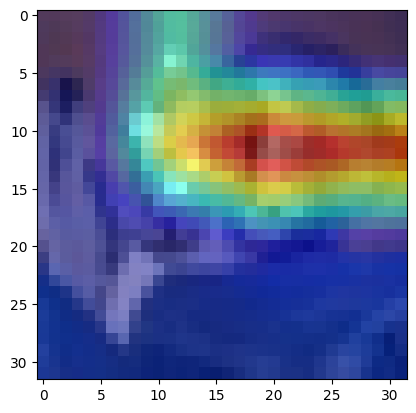

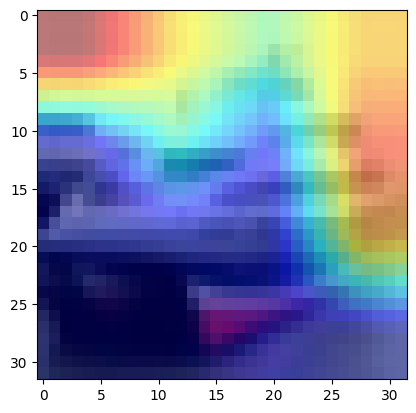

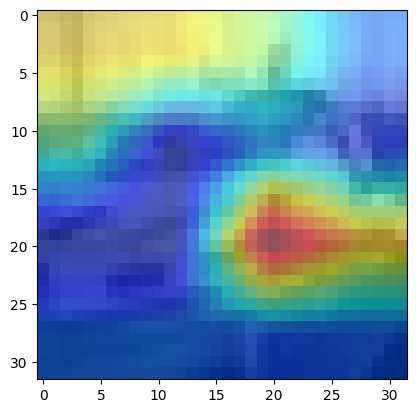

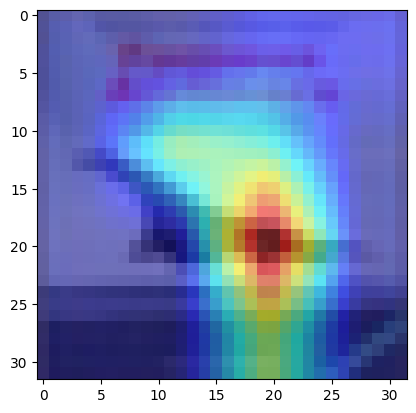

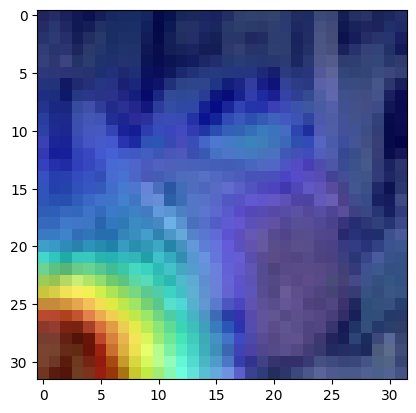

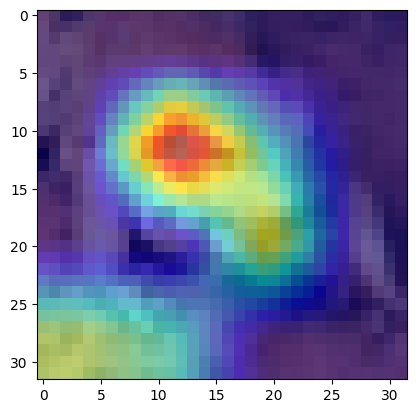

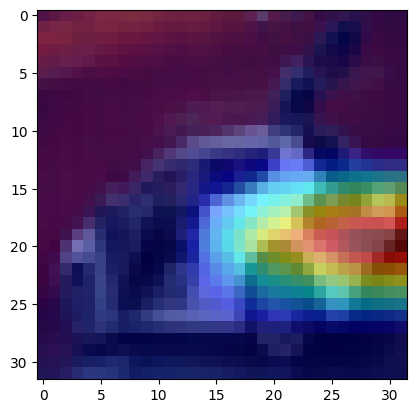

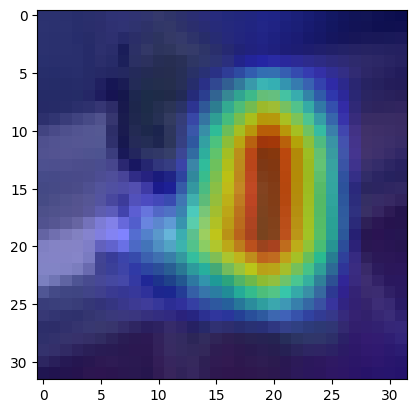

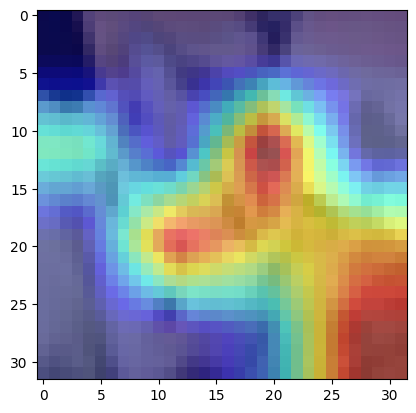

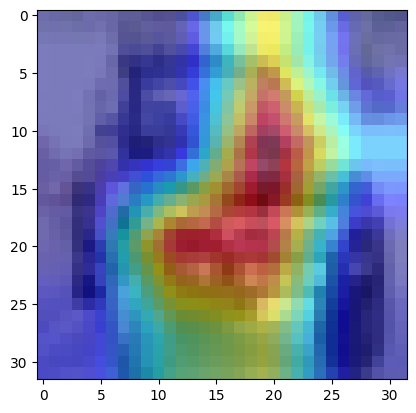

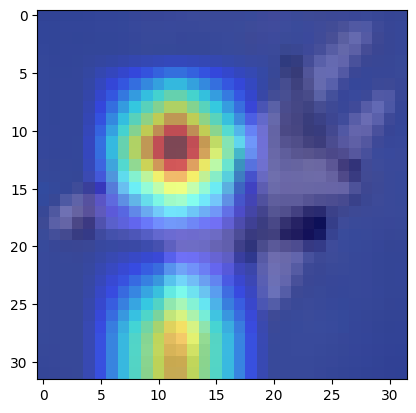

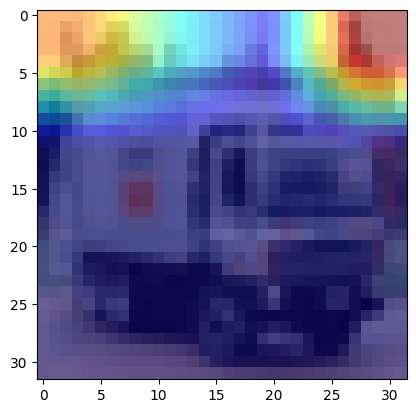

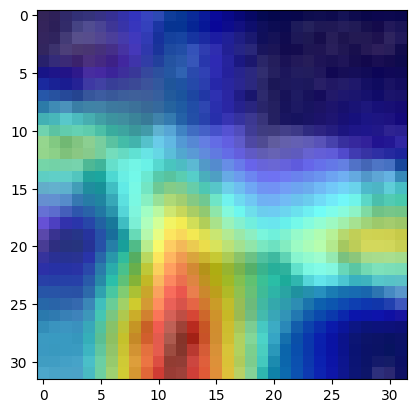

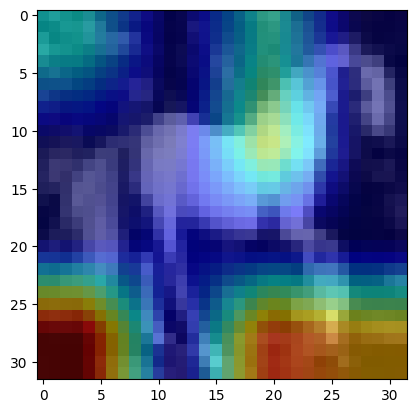

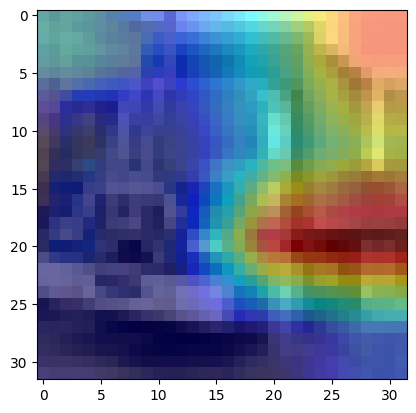

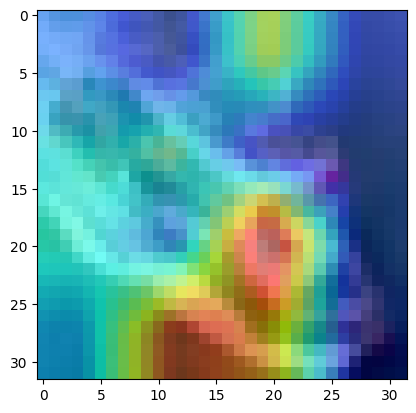

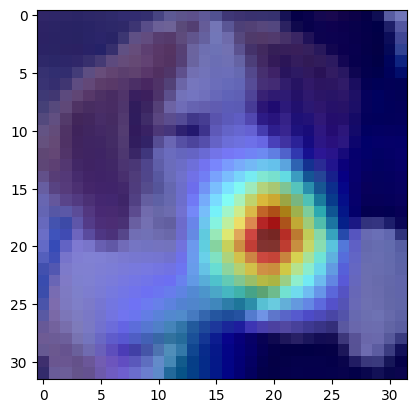

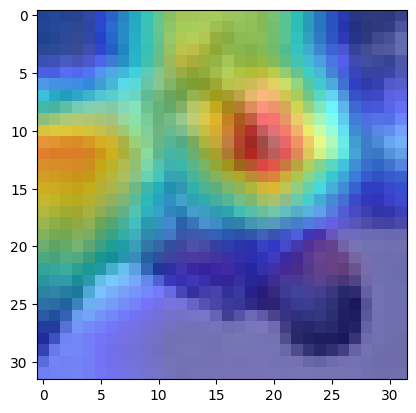

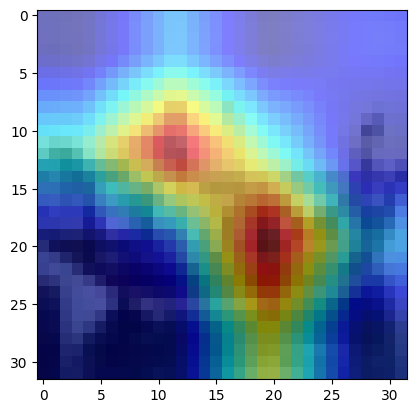

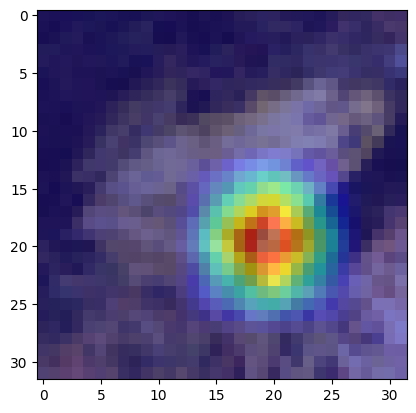

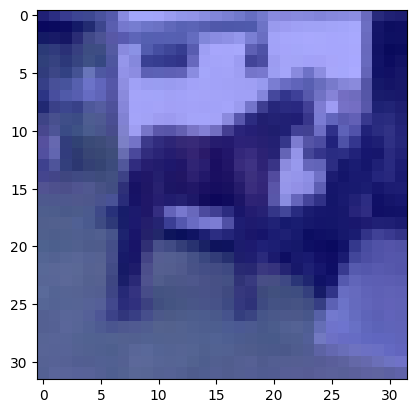

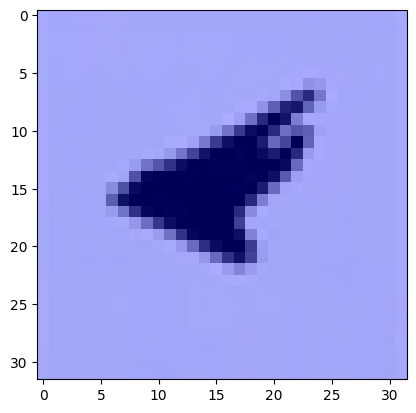

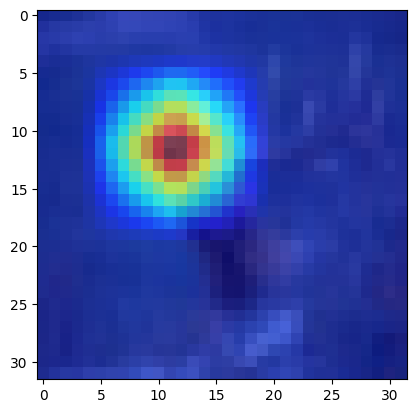

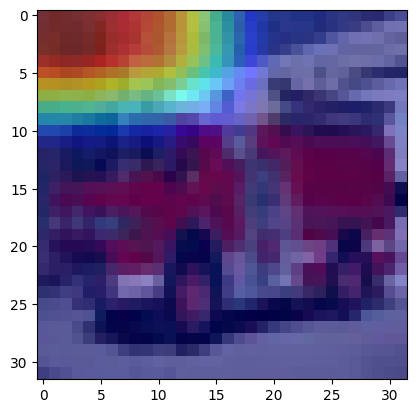

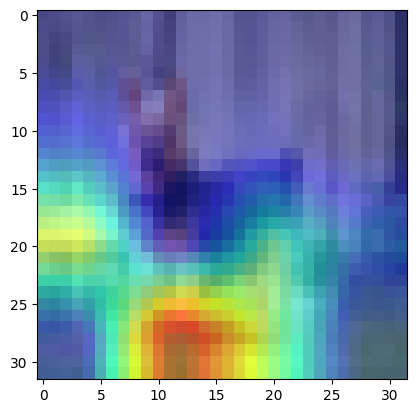

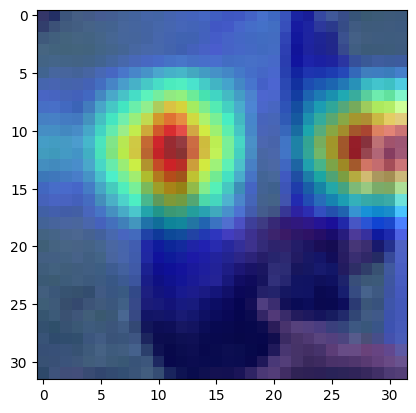

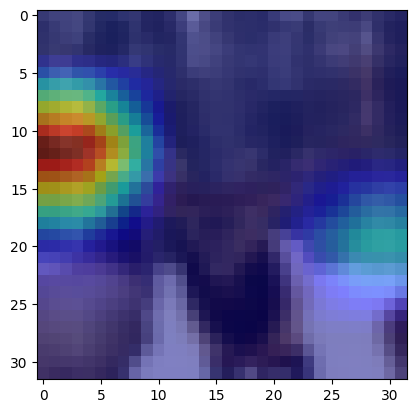

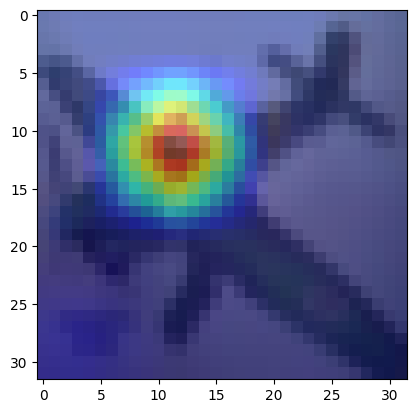

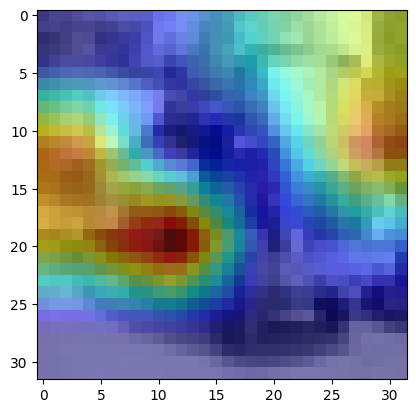

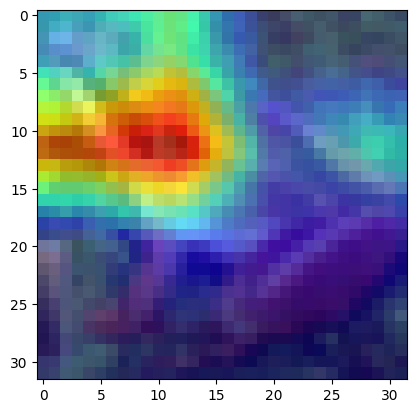

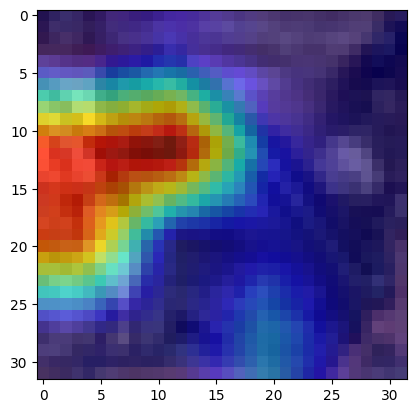

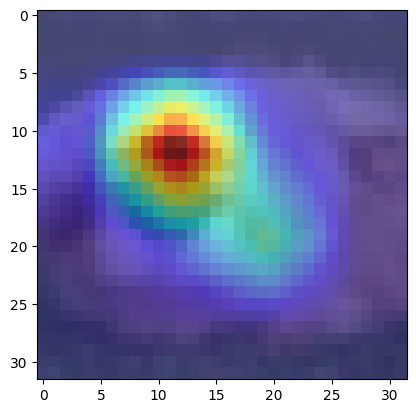

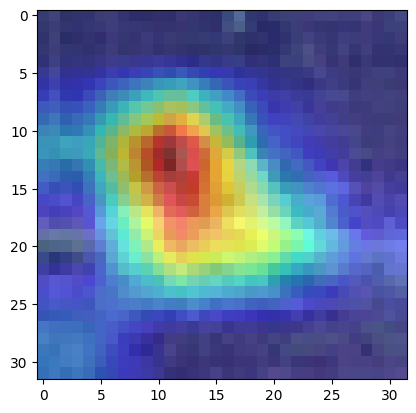

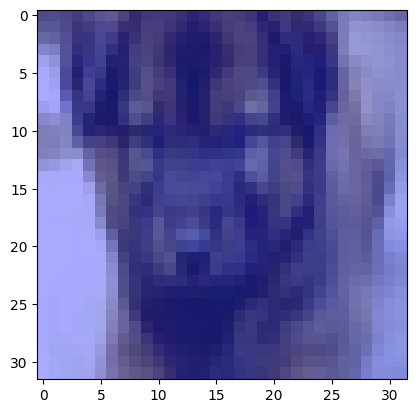

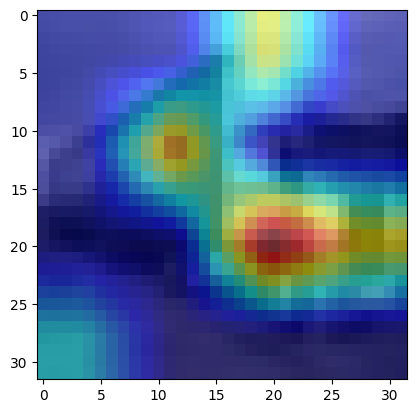

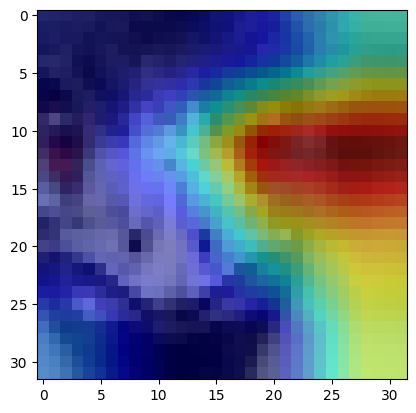

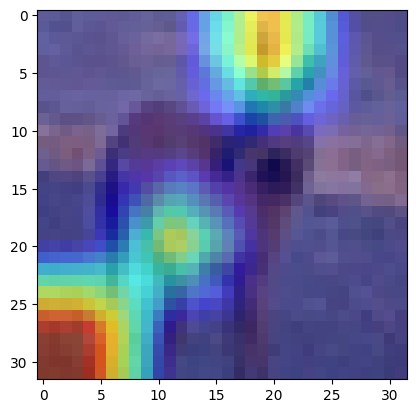

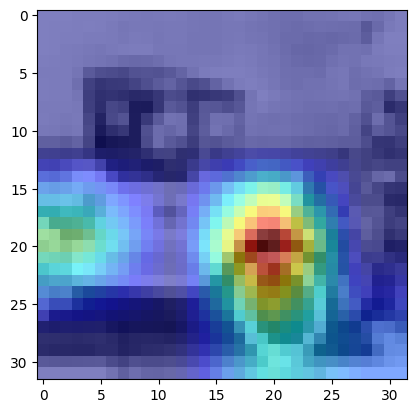

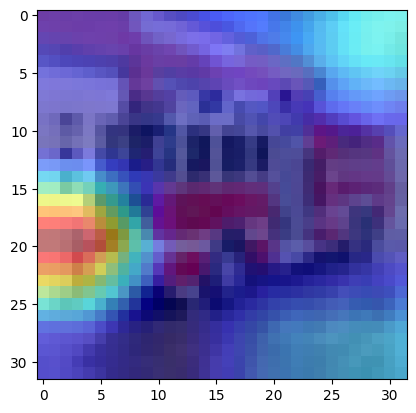

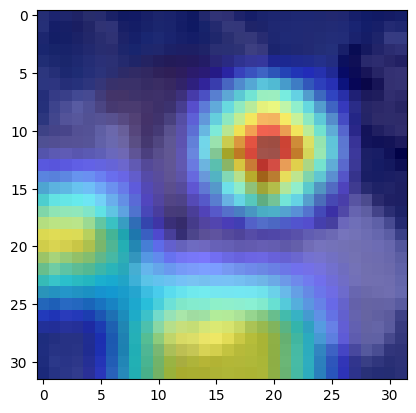

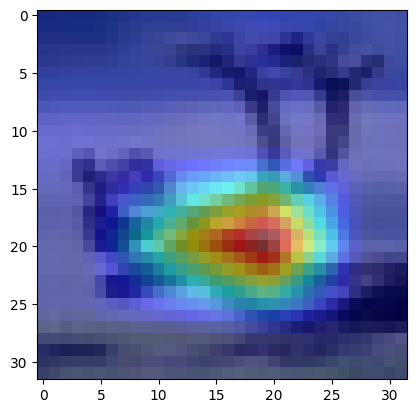

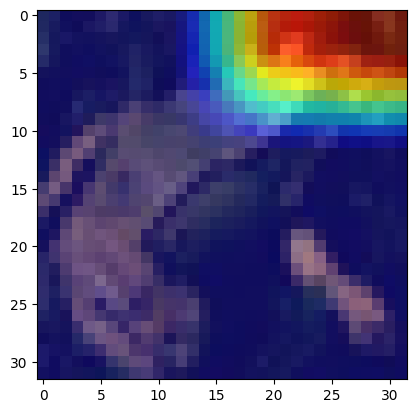

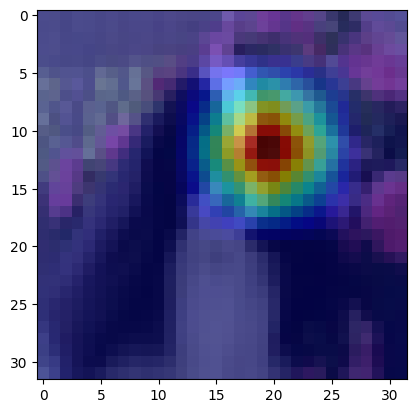

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

In [13]:
for data, target in cifar_testset:

    input_tensor = preprocess_image(data,
                            mean=means,
                            std=stds)
    target_layers = [model.model.layer3[-1]]
    targets = [ClassifierOutputTarget(target)]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    rgb_img = np.float32(data) / 255
    visualization = np.array(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.5))
    plt.imshow(visualization)
    plt.show()

In [14]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

def inference(wants_gradcam, n_gradcam, target_layer_number, transparency, wants_misclassified, n_misclassified, input_img = None, n_top_classes=10):

    if wants_gradcam:

      outputs_inference_gc = []
      count_gradcam = 1

      for data, target in cifar_testset:

        input_tensor = preprocess_image(data,
                                mean=means,
                                std=stds)
        target_layers = [model.model.layer3[target_layer_number]]
        targets = [ClassifierOutputTarget(target)]
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        rgb_img = np.float32(data) / 255
        visualization = np.array(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency))
        outputs_inference_gc.append(visualization)

        count_gradcam += 1
        if count_gradcam > n_gradcam:
          break
    else:
      outputs_inference_gc = None

    if wants_misclassified:
      outputs_inference_mis = []
      count_mis = 1

      for data_, target in cifar_testset:

        data = transform(data_)
        data = data.unsqueeze(0)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        if pred.item()!=target:

            count_mis += 1


            fig = plt.figure()
            fig.add_subplot(111)

            plt.imshow(data_)
            plt.title(f'Target: {classes[target]}\nPred: {classes[pred.item()]}')
            plt.axis('off')

            fig.canvas.draw()

            fig_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            fig_img = fig_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            plt.close(fig)

            outputs_inference_mis.append(fig_img)

        if count_mis > n_misclassified:
            break

    else:
      outputs_inference_mis = None

    if input_img is not None:
        data = transform(input_img)
        data = data.unsqueeze(0)
        output = model(data)
        softmax = torch.nn.Softmax(dim=0)
        o = softmax(output.flatten())
        confidences = {classes[i]: float(o[i]) for i in range(10)}
        _, prediction = torch.max(output, 1)

        confidences = {k: v for k, v in sorted(confidences.items(), key=lambda item: item[1], reverse=True)}
        confidences = dict(itertools.islice(confidences.items(), n_top_classes))
    else:
      confidences = None


    return outputs_inference_gc, outputs_inference_mis, confidences

In [15]:

title = "CIFAR10 trained on Custom ResNet Model with GradCAM"
description = "A simple Gradio interface to infer on ResNet model, and get GradCAM results"
examples = [[None, None, None, None, None, None, '0010'+'.jpg', None] for i in range(10)]

demo = gr.Interface(inference,
                    inputs = [gr.Checkbox(False, label='Do you want to see GradCAM outputs?'),
                              gr.Slider(0, 10, value = 0, step=1, label="How many?"),
                              gr.Slider(-2, -1, value = -2, step=1, label="Which target layer?"),
                              gr.Slider(0, 1, value = 0, label="Opacity of GradCAM"),
                              gr.Checkbox(False, label='Do you want to see misclassified images?'),
                              gr.Slider(0, 10, value = 0, step=1, label="How many?"),
                              gr.Image(shape=(32, 32), label="Input image"),
                              gr.Slider(0, 10, value = 0, step=1, label="How many top classes you want to see?")
                              ],
                    outputs = [
                              gr.Gallery(label="GradCAM Outputs", show_label=True, elem_id="gallery").style(columns=[2], rows=[2], object_fit="contain", height="auto"),
                              gr.Gallery(label="Misclassified Images", show_label=True, elem_id="gallery").style(columns=[2], rows=[2], object_fit="contain", height="auto"),
                              gr.Label(num_top_classes=None)
                              ],
                    title = title,
                    description = description,
                    examples = examples
                    )
demo.launch()

<ipython-input-15-c9b9a35a0240>:16: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Gallery(label="GradCAM Outputs", show_label=True, elem_id="gallery").style(columns=[2], rows=[2], object_fit="contain", height="auto"),
<ipython-input-15-c9b9a35a0240>:17: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Gallery(label="Misclassified Images", show_label=True, elem_id="gallery").style(columns=[2], rows=[2], object_fit="contain", height="auto"),


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>